<img style="float: left; margin: 30px 15px 15px 15px;" src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png" width="300" height="500" /> 
    
    
### <font color='navy'> Simulación de procesos financieros. 

**Nombres:** Sebastián González, José Antonio Contreras Peña y Tania Bell Nicholls

**Fecha:** 23 de noviembre del 2021.

**Expediente** : IF726767 y .
**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**: https://github.com/Tania-Bell/Tarea9_TBell_JAContreras_SGonzalez.git

# Tarea 9: Clase 23

## Enunciado de tarea 

Implementar el método de esquemas del trapecio, para valuar la opción call y put asiática con precio inicial, $S_0 = 100$, precio de ejercicio $K = 100$, tasa libre de riesgo $r = 0.10$, volatilidad $\sigma = 0.20$ y $T = 1$ año. Cuyo precio es $\approx 7.04$. Realizar la simulación en base a la siguiente tabla:
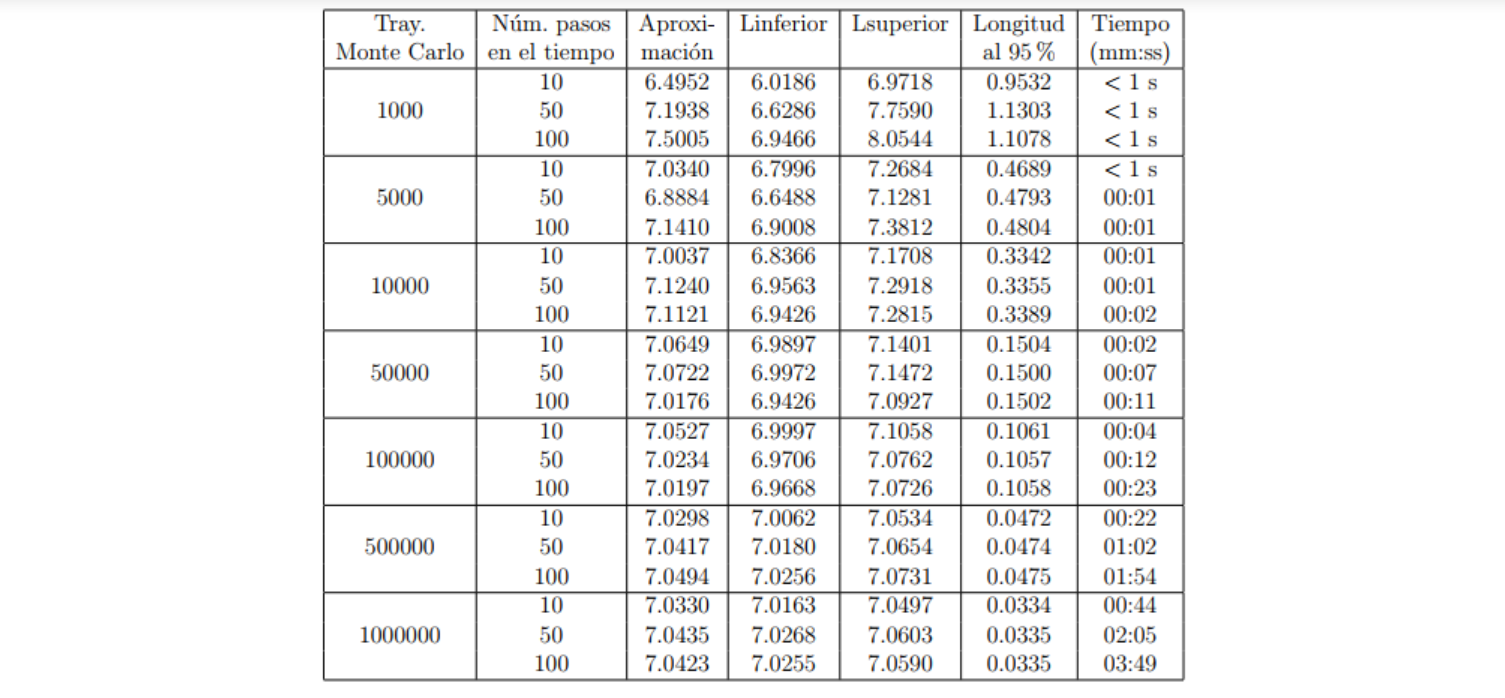

Observe que en esta tabla se encuentran los intervalos de confianza de la aproximación obtenida y además el tiempo de simulación que tarda en encontrar la respuesta cada método. 
- Se debe entonces realizar una simulación para la misma cantidad de trayectorias y número de pasos y construir una Dataframe de pandas para reportar todos los resultados obtenidos.**(70 puntos)**
- Compare los resultados obtenidos con los resultados arrojados por la función `Riemann_approach`. Concluya. **(30 puntos)**

Se habilitará un enlace en canvas donde se adjuntará los resultados de dicha tarea

>**Nota:** Para generar índices de manera como se especifica en la tabla referirse a:
> - https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html
> - https://jakevdp.github.io/PythonDataScienceHandbook/03.05-hierarchical-indexing.html
> - https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.MultiIndex.html


## Código de solución estudiante 1: Tania

## Código de solución estudiante 2: Jose Antonio

In [1]:
# Importamos librerías a utilizar.
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import datetime
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import time
%matplotlib inline

# Algunas opciones para Pandas.
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 9)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)

In [2]:
def BSprices(mu,sigma,S0,NbTraj,NbStep):
    """
    Expresión de la solución de la ecuación de Black-Scholes
    St = S0*exp((r-sigma^2/2)*t+ sigma*DeltaW)
    
    Parámetros
    ---------
    mu    : Tasa libre de riesgo
    sigma : Desviación estándar de los rendimientos
    S0    : Precio inicial del activo subyacente
    NbTraj: Cantidad de trayectorias a simular
    NbStep: Número de días a simular
    """
    # Datos para la fórmula de St
    nu = mu-(sigma**2)/2
    DeltaT = 1/NbStep
    SqDeltaT = np.sqrt(DeltaT)
    DeltaW = SqDeltaT*np.random.randn(NbTraj,NbStep-1)
    
    # Se obtiene --> Ln St = Ln S0+ nu*DeltaT + sigma*DeltaW
    increments = nu*DeltaT + sigma*DeltaW
    concat = np.concatenate((np.log(S0)*np.ones([NbTraj,1]),increments),axis=1)
    
    # Se utiliza cumsum por que se quiere simular los precios iniciando desde S0
    LogSt = np.cumsum(concat,axis=1)
    # Se obtienen los precios simulados para los NbStep fijados
    St = np.exp(LogSt)
    # Vector con la cantidad de días simulados
    t = np.arange(0,NbStep)

    return St.T,t

In [3]:
def Riemann_approach(K:'Strike price',
                     r:'Tasa libre de riesgo',
                     S0:'Precio inicial',
                     NbTraj:'Número trayectorias',
                     NbStep:'Cantidad de pasos a simular',
                     sigma:'Volatilidad',T:'Tiempo de cierre del contrato en años',
                     Option_Type: 'Tipo de opción a valuar. Call o Put.',
                     Trust_level: 'Confianza definida para el intervalo de precios',
                     flag=None):
    # Definimos tiempo de ejecución
    start = time.time()
    
    # Resolvemos la ecuación de black scholes para obtener los precios
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    # Almacenamos los precios en un dataframe
    prices = pd.DataFrame(St,index=t)
    # Obtenemos los precios promedios
    Average_t = prices.expanding().mean()
    # Definimos el dataframe de strikes
    strike = K
    
    if Option_Type in ['Call', 'call']:
        # Calculamos el call de la opción según la formula obtenida para Sumas de Riemann
        call = pd.DataFrame({'Prima': np.exp(-r*T) \
                     *np.fmax(Average_t - strike, 0).mean(axis=1)}, index=t)
        # Intervalo de confianza
        sigma_est_call = call.sem().Prima
        mean_est_call = call.iloc[-1].Prima
        i1_call = st.norm.interval(Trust_level, loc=mean_est_call, scale=sigma_est_call)
        
        end_c = time.time()
        total_time_c = end_c - start

        return call.iloc[-1].Prima, i1_call[0], i1_call[1], i1_call[1] - i1_call[0], total_time_c
    else:
        # Calculamos el put de la opción según la formula obtenida para Sumas de Riemann
        put = pd.DataFrame({'Prima': np.exp(-r*T) \
                     *np.fmax(strike - Average_t, 0).mean(axis=1)}, index=t)
        # Intervalo de confianza
        sigma_est_put = put.sem().Prima
        mean_est_put = put.iloc[-1].Prima
        i1_put = st.norm.interval(Trust_level, loc=mean_est_put, scale=sigma_est_put)
        
        end_p = time.time()
        total_time_p = end_p - start

        return put.iloc[-1].Prima, i1_put[0], i1_put[1], i1_put[1] - i1_put[0], total_time_p

In [4]:
def Trapeze_approach(K:'Strike price',
                     r:'Tasa libre de riesgo',
                     S0:'Precio inicial',
                     NbTraj:'Número trayectorias',
                     NbStep:'Cantidad de pasos a simular',
                     sigma:'Volatilidad',T:'Tiempo de cierre del contrato en años',
                     Option_Type: 'Tipo de opción a valuar. Call o Put.',
                     Trust_level: 'Confianza definida para el intervalo de precios',
                     flag=None):
    # Definimos tiempo de ejecución
    start = time.time()
    
    # Resolvemos la ecuación de black scholes para obtener los precios
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    # Almacenamos los precios en un dataframe
    prices = pd.DataFrame(St,index=t)
    # Definimos la longitud h
    h = T / NbStep
    # Definimos el dataframe de strikes
    strike = K
    
    if Option_Type in ['Call', 'call']:
        # Definimos el trapecio para el call
        Average_trapeze_c = (prices * (2 + (r*h) + ((np.random.randn(NbStep, NbTraj)) * sigma))).expanding().sum()
        
        # Calculamos el call de la opción según la formula obtenida para el trapecio
        call = pd.DataFrame({'Prima': np.exp(-r*T) \
                     *np.fmax((h/2*T) * Average_trapeze_c - strike, 0).mean(axis=1)}, index=t)
        # Intervalo de confianza
        sigma_est_call = call.sem().Prima
        mean_est_call = call.iloc[-1].Prima
        i1_call = st.norm.interval(Trust_level, loc=mean_est_call, scale=sigma_est_call)
        
        end_c = time.time()
        total_time_c = end_c - start

        return call.iloc[-1].Prima, i1_call[0], i1_call[1], i1_call[1] - i1_call[0], total_time_c
    
    else:
        # Definimos el trapecio para el put
        Average_trapeze_p = (prices * (2 + (r*h) + ((np.random.randn(NbStep, NbTraj)) * sigma))).expanding().sum()
        
        # Calculamos el put de la opción según la formula obtenida para el trapecio
        put = pd.DataFrame({'Prima': np.exp(-r*T) \
                     *np.fmax(strike - (h/2*T) * Average_trapeze_p, 0).mean(axis=1)}, index=t)
        # Intervalo de confianza
        sigma_est_put = put.sem().Prima
        mean_est_put = put.iloc[-1].Prima
        i1_put = st.norm.interval(Trust_level, loc=mean_est_put, scale=sigma_est_put)
        
        end_p = time.time()
        total_time_p = end_p - start
    
        return put.iloc[-1].Prima, i1_put[0], i1_put[1], i1_put[1] - i1_put[0], total_time_p

Call Asiatico

In [5]:
N_traj = [1000] * 3 + [5000] * 3 + [10000] * 3 + [50000] * 3 + [100000] * 3 + [500000] * 3 +  [1000000] * 3
N_step = [10, 50, 100] * len(set(N_traj))
index = [N_traj, N_step]

# Valores de la opción.
S0 = 100
K = 100
r = 0.10
sigma = 0.20
T = 1

In [6]:
N_traj_sim = [1000, 5000, 10000, 50000, 100000, 500000, 1000000]
N_step_sim = [10, 50, 100]
sim_riemann_call = [[Riemann_approach(K, r, S0, j, i, sigma, T, 'Call', 0.95) for i in N_step_sim] for j in N_traj_sim]

In [7]:
def get_matrix_values(simulation_vector):
    
    # Definimos las trayectorias, particularmente será para 7.
    Tray_1 = ([np.array(simulation_vector[i]) for i in range(len(simulation_vector))][0])
    Tray_2 = ([np.array(simulation_vector[i]) for i in range(len(simulation_vector))][1])
    Tray_3 = ([np.array(simulation_vector[i]) for i in range(len(simulation_vector))][2])
    Tray_4 = ([np.array(simulation_vector[i]) for i in range(len(simulation_vector))][3])
    Tray_5 = ([np.array(simulation_vector[i]) for i in range(len(simulation_vector))][4])
    Tray_6 = ([np.array(simulation_vector[i]) for i in range(len(simulation_vector))][5])
    Tray_7 = ([np.array(simulation_vector[i]) for i in range(len(simulation_vector))][6])

    # Concatenamos los vectores y lo almacenamos en una matriz.
    matrix = np.concatenate([Tray_1, Tray_2, Tray_3, Tray_4, Tray_5, Tray_6, Tray_7])
    
    return matrix

In [8]:
data_call_riemann = pd.DataFrame(get_matrix_values(sim_riemann_call),
                                 columns=['Aproximación', 'Linferior', 'Lsuperior', 'Longitud al 95%', 'Tiempo en segundos'],
                                 index=pd.MultiIndex.from_arrays(index, names=('Tray. Montecarlo', 'Num. pasos en el tiempo')))
pd.options.display.max_rows = None
data_call_riemann

Aproximación  Linferior  \
Tray. Montecarlo Num. pasos en el tiempo                            
1000             10                              5.948      4.770   
                 50                              7.056      6.521   
                 100                             7.062      6.697   
5000             10                              6.410      5.141   
                 50                              7.062      6.531   
                 100                             6.864      6.510   
10000            10                              6.393      5.126   
                 50                              6.805      6.299   
                 100                             6.913      6.556   
50000            10                              6.405      5.135   
                 50                              6.903      6.388   
                 100                             7.024      6.661   
100000           10                              6.421      5.149   
                 50                              6.944      6.425   
                 100                             6.953      6.595   
500000           10                              6.428      5.154   
                 50                              6.941      6.422   
                 100                             6.979      6.619   
1000000          10                              6.422      5.148   
                 50                              6.934      6.416   
                 100                             6.987      6.627   

                                          Lsuperior  Longitud al 95%  \
Tray. Montecarlo Num. pasos en el tiempo                               
1000             10                           7.126            2.356   
                 50                           7.592            1.071   
                 100                          7.427            0.730   
5000             10                           7.678            2.537   
                 50                           7.592            1.061   
                 100                          7.217            0.706   
10000            10                           7.659            2.533   
                 50                           7.312            1.013   
                 100                          7.270            0.714   
50000            10                           7.674            2.539   
                 50                           7.418            1.029   
                 100                          7.387            0.726   
100000           10                           7.693            2.545   
                 50                           7.462            1.038   
                 100                          7.311            0.717   
500000           10                           7.702            2.548   
                 50                           7.460            1.037   
                 100                          7.339            0.719   
1000000          10                           7.695            2.546   
                 50                           7.452            1.036   
                 100                          7.347            0.720   

                                          Tiempo en segundos  
Tray. Montecarlo Num. pasos en el tiempo                      
1000             10                                    0.026  
                 50                                    0.021  
                 100                                   0.023  
5000             10                                    0.084  
                 50                                    0.084  
                 100                                   0.104  
10000            10                                    0.144  
                 50                                    0.172  
                 100                                   0.207  
50000            10                                    0.740  
                 50                      

Trapecio

In [9]:
sim_trapeze_call = [[Trapeze_approach(K, r, S0, j, i, sigma, T, 'Call', 0.95) for i in N_step_sim] for j in N_traj_sim]

In [10]:
data_call_trapeze = pd.DataFrame(get_matrix_values(sim_trapeze_call),
                                 columns=['Aproximación', 'Linferior', 'Lsuperior', 'Longitud al 95%', 'Tiempo en segundos'],
                                 index=pd.MultiIndex.from_arrays(index, names=('Tray. Montecarlo', 'Num. pasos en el tiempo')))
pd.options.display.max_rows = None
data_call_trapeze

Aproximación  Linferior  \
Tray. Montecarlo Num. pasos en el tiempo                            
1000             10                              6.813      5.479   
                 50                              6.753      6.359   
                 100                             6.631      6.372   
5000             10                              6.881      5.532   
                 50                              7.113      6.691   
                 100                             7.063      6.784   
10000            10                              6.787      5.456   
                 50                              7.045      6.628   
                 100                             6.941      6.668   
50000            10                              6.874      5.526   
                 50                              7.019      6.604   
                 100                             7.035      6.759   
100000           10                              6.887      5.536   
                 50                              6.960      6.549   
                 100                             7.024      6.748   
500000           10                              6.904      5.550   
                 50                              7.015      6.601   
                 100                             6.994      6.719   
1000000          10                              6.893      5.541   
                 50                              7.015      6.600   
                 100                             7.015      6.739   

                                          Lsuperior  Longitud al 95%  \
Tray. Montecarlo Num. pasos en el tiempo                               
1000             10                           8.147            2.668   
                 50                           7.146            0.786   
                 100                          6.889            0.517   
5000             10                           8.230            2.698   
                 50                           7.534            0.843   
                 100                          7.342            0.557   
10000            10                           8.119            2.663   
                 50                           7.463            0.835   
                 100                          7.214            0.546   
50000            10                           8.222            2.696   
                 50                           7.434            0.830   
                 100                          7.312            0.553   
100000           10                           8.238            2.701   
                 50                           7.371            0.822   
                 100                          7.300            0.552   
500000           10                           8.258            2.708   
                 50                           7.429            0.829   
                 100                          7.269            0.550   
1000000          10                           8.245            2.704   
                 50                           7.429            0.828   
                 100                          7.290            0.552   

                                          Tiempo en segundos  
Tray. Montecarlo Num. pasos en el tiempo                      
1000             10                                    0.032  
                 50                                    0.029  
                 100                                   0.029  
5000             10                                    0.090  
                 50                                    0.129  
                 100                                   0.153  
10000            10                                    0.189  
                 50                                    0.269  
                 100                                   0.276  
50000            10                                    0.877  
                 50                      

Puts asiaticos

Riemann

In [12]:
sim_riemann_put = [[Riemann_approach(K, r, S0, j, i, sigma, T, 'Put', 0.95) for i in N_step_sim] for j in N_traj_sim]

In [13]:
data_put_riemann = pd.DataFrame(get_matrix_values(sim_riemann_put),
                                 columns=['Aproximación', 'Linferior', 'Lsuperior', 'Longitud al 95%', 'Tiempo en segundos'],
                                 index=pd.MultiIndex.from_arrays(index, names=('Tray. Montecarlo', 'Num. pasos en el tiempo')))
pd.options.display.max_rows = None
data_put_riemann

Aproximación  Linferior  \
Tray. Montecarlo Num. pasos en el tiempo                            
1000             10                              2.142      1.736   
                 50                              2.287      2.142   
                 100                             2.350      2.247   
5000             10                              2.167      1.754   
                 50                              2.395      2.244   
                 100                             2.282      2.188   
10000            10                              2.256      1.822   
                 50                              2.407      2.253   
                 100                             2.382      2.281   
50000            10                              2.219      1.793   
                 50                              2.314      2.167   
                 100                             2.340      2.240   
100000           10                              2.223      1.797   
                 50                              2.339      2.191   
                 100                             2.355      2.255   
500000           10                              2.218      1.793   
                 50                              2.332      2.184   
                 100                             2.345      2.245   
1000000          10                              2.223      1.797   
                 50                              2.341      2.192   
                 100                             2.351      2.251   

                                          Lsuperior  Longitud al 95%  \
Tray. Montecarlo Num. pasos en el tiempo                               
1000             10                           2.549            0.813   
                 50                           2.432            0.290   
                 100                          2.453            0.206   
5000             10                           2.581            0.826   
                 50                           2.545            0.302   
                 100                          2.377            0.190   
10000            10                           2.690            0.868   
                 50                           2.560            0.307   
                 100                          2.484            0.204   
50000            10                           2.644            0.851   
                 50                           2.460            0.292   
                 100                          2.439            0.199   
100000           10                           2.649            0.852   
                 50                           2.487            0.296   
                 100                          2.455            0.200   
500000           10                           2.643            0.850   
                 50                           2.480            0.296   
                 100                          2.444            0.199   
1000000          10                           2.649            0.852   
                 50                           2.490            0.297   
                 100                          2.451            0.200   

                                          Tiempo en segundos  
Tray. Montecarlo Num. pasos en el tiempo                      
1000             10                                    0.019  
                 50                                    0.020  
                 100                                   0.024  
5000             10                                    0.075  
                 50                                    0.090  
                 100                                   0.107  
10000            10                                    0.157  
                 50                                    0.184  
                 100                                   0.221  
50000            10                                    0.821  
                 50                      

Trapecio

In [14]:
sim_trapeze_put = [[Trapeze_approach(K, r, S0, j, i, sigma, T, 'Put', 0.95) for i in N_step_sim] for j in N_traj_sim]

In [15]:
data_put_trapeze = pd.DataFrame(get_matrix_values(sim_trapeze_put),
                                 columns=['Aproximación', 'Linferior', 'Lsuperior', 'Longitud al 95%', 'Tiempo en segundos'],
                                 index=pd.MultiIndex.from_arrays(index, names=('Tray. Montecarlo', 'Num. pasos en el tiempo')))
pd.options.display.max_rows = None
data_put_trapeze

Aproximación  Linferior  \
Tray. Montecarlo Num. pasos en el tiempo                            
1000             10                              2.231    -14.872   
                 50                              2.483     -4.979   
                 100                             2.333     -2.929   
5000             10                              2.201    -14.921   
                 50                              2.317     -5.140   
                 100                             2.331     -2.925   
10000            10                              2.236    -14.875   
                 50                              2.346     -5.113   
                 100                             2.352     -2.904   
50000            10                              2.210    -14.912   
                 50                              2.367     -5.089   
                 100                             2.338     -2.921   
100000           10                              2.242    -14.872   
                 50                              2.317     -5.148   
                 100                             2.368     -2.888   
500000           10                              2.224    -14.894   
                 50                              2.332     -5.131   
                 100                             2.352     -2.906   
1000000          10                              2.221    -14.898   
                 50                              2.347     -5.113   
                 100                             2.344     -2.914   

                                          Lsuperior  Longitud al 95%  \
Tray. Montecarlo Num. pasos en el tiempo                               
1000             10                          19.333           34.204   
                 50                           9.946           14.925   
                 100                          7.594           10.524   
5000             10                          19.322           34.243   
                 50                           9.774           14.913   
                 100                          7.588           10.513   
10000            10                          19.347           34.223   
                 50                           9.804           14.917   
                 100                          7.607           10.511   
50000            10                          19.331           34.243   
                 50                           9.823           14.913   
                 100                          7.597           10.518   
100000           10                          19.357           34.229   
                 50                           9.782           14.930   
                 100                          7.623           10.511   
500000           10                          19.341           34.235   
                 50                           9.795           14.926   
                 100                          7.609           10.514   
1000000          10                          19.339           34.237   
                 50                           9.807           14.921   
                 100                          7.602           10.516   

                                          Tiempo en segundos  
Tray. Montecarlo Num. pasos en el tiempo                      
1000             10                                    0.031  
                 50                                    0.023  
                 100                                   0.029  
5000             10                                    0.079  
                 50                                    0.109  
                 100                                   0.131  
10000            10                                    0.158  
                 50                                    0.205  
                 100                                   0.256  
50000            10                                    0.820  
                 50                      

Para las opciones call podemos apreciar que el metodo de Riemman tiene menor carga computacional y dan una prima bastante similar, mismo es caso con las opciones put que tiene una muy ligera variacion en el precio de la prima.

## Código de solución estudiante 3: Sebastián

In [7]:
#importar los paquetes que se van a usar
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import datetime
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import time
%matplotlib inline
#algunas opciones para Pandas
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 9)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)

In [2]:
def BSprices(mu,sigma,S0,NbTraj,NbStep):
    """
    Expresión de la solución de la ecuación de Black-Scholes
    St = S0*exp((r-sigma^2/2)*t+ sigma*DeltaW)
    
    Parámetros
    ---------
    mu    : Tasa libre de riesgo
    sigma : Desviación estándar de los rendimientos
    S0    : Precio inicial del activo subyacente
    NbTraj: Cantidad de trayectorias a simular
    NbStep: Número de días a simular
    """
    # Datos para la fórmula de St
    nu = mu-(sigma**2)/2
    DeltaT = 1/NbStep
    SqDeltaT = np.sqrt(DeltaT)
    DeltaW = SqDeltaT*np.random.randn(NbTraj,NbStep-1)
    
    # Se obtiene --> Ln St = Ln S0+ nu*DeltaT + sigma*DeltaW
    increments = nu*DeltaT + sigma*DeltaW
    concat = np.concatenate((np.log(S0)*np.ones([NbTraj,1]),increments),axis=1)
    
    # Se utiliza cumsum por que se quiere simular los precios iniciando desde S0
    LogSt = np.cumsum(concat,axis=1)
    # Se obtienen los precios simulados para los NbStep fijados
    St = np.exp(LogSt)
    # Vector con la cantidad de días simulados
    t = np.arange(0,NbStep)

    return St.T,t

def calc_daily_ret(closes):
    return np.log(closes/closes.shift(1)).iloc[1:]

In [3]:
# Función donde se almacenan todos los resultados
def Riemann_approach(K:'Strike price',
                     r:'Tasa libre de riesgo',
                     S0:'Precio inicial',
                     NbTraj:'Número trayectorias',
                     NbStep:'Cantidad de pasos a simular',
                     sigma:'Volatilidad',T:'Tiempo de cierre del contrato en años',
                     Option_Type: 'Tipo de opción a valuar. Call o Put.',
                     Trust_level: 'Confianza definida para el intervalo de precios',
                     flag=None):
    # Definimos tiempo de ejecución
    start = time.time()
    
    # Resolvemos la ecuación de black scholes para obtener los precios
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    # Almacenamos los precios en un dataframe
    prices = pd.DataFrame(St,index=t)
    # Obtenemos los precios promedios
    Average_t = prices.expanding().mean()
    # Definimos el dataframe de strikes
    strike = K
    
    if Option_Type in ['Call', 'call']:
        # Calculamos el call de la opción según la formula obtenida para Sumas de Riemann
        call = pd.DataFrame({'Prima': np.exp(-r*T) \
                     *np.fmax(Average_t - strike, 0).mean(axis=1)}, index=t)
        # Intervalo de confianza
        sigma_est_call = call.sem().Prima
        mean_est_call = call.iloc[-1].Prima
        i1_call = st.norm.interval(Trust_level, loc=mean_est_call, scale=sigma_est_call)
        
        end_c = time.time()
        total_time_c = end_c - start

        return call.iloc[-1].Prima, i1_call[0], i1_call[1], i1_call[1] - i1_call[0], total_time_c
    else:
        # Calculamos el put de la opción según la formula obtenida para Sumas de Riemann
        put = pd.DataFrame({'Prima': np.exp(-r*T) \
                     *np.fmax(strike - Average_t, 0).mean(axis=1)}, index=t)
        # Intervalo de confianza
        sigma_est_put = put.sem().Prima
        mean_est_put = put.iloc[-1].Prima
        i1_put = st.norm.interval(Trust_level, loc=mean_est_put, scale=sigma_est_put)
        
        end_p = time.time()
        total_time_p = end_p - start

        return put.iloc[-1].Prima, i1_put[0], i1_put[1], i1_put[1] - i1_put[0], total_time_p

In [4]:
def Trapeze_approach(K:'Strike price',
                     r:'Tasa libre de riesgo',
                     S0:'Precio inicial',
                     NbTraj:'Número trayectorias',
                     NbStep:'Cantidad de pasos a simular',
                     sigma:'Volatilidad',T:'Tiempo de cierre del contrato en años',
                     Option_Type: 'Tipo de opción a valuar. Call o Put.',
                     Trust_level: 'Confianza definida para el intervalo de precios',
                     flag=None):
    # Definimos tiempo de ejecución
    start = time.time()
    
    # Resolvemos la ecuación de black scholes para obtener los precios
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    # Almacenamos los precios en un dataframe
    prices = pd.DataFrame(St,index=t)
    # Definimos la longitud h
    h = T / NbStep
    # Definimos el dataframe de strikes
    strike = K
    
    if Option_Type in ['Call', 'call']:
        # Definimos el trapecio para el call
        Average_trapeze_c = (prices * (2 + (r*h) + ((np.random.randn(NbStep, NbTraj)) * sigma))).expanding().sum()
        
        # Calculamos el call de la opción según la formula obtenida para el trapecio
        call = pd.DataFrame({'Prima': np.exp(-r*T) \
                     *np.fmax((h/2*T) * Average_trapeze_c - strike, 0).mean(axis=1)}, index=t)
        # Intervalo de confianza
        sigma_est_call = call.sem().Prima
        mean_est_call = call.iloc[-1].Prima
        i1_call = st.norm.interval(Trust_level, loc=mean_est_call, scale=sigma_est_call)
        
        end_c = time.time()
        total_time_c = end_c - start

        return call.iloc[-1].Prima, i1_call[0], i1_call[1], i1_call[1] - i1_call[0], total_time_c
    
    else:
        # Definimos el trapecio para el put
        Average_trapeze_p = (prices * (2 + (r*h) + ((np.random.randn(NbStep, NbTraj)) * sigma))).expanding().sum()
        
        # Calculamos el put de la opción según la formula obtenida para el trapecio
        put = pd.DataFrame({'Prima': np.exp(-r*T) \
                     *np.fmax(strike - (h/2*T) * Average_trapeze_p, 0).mean(axis=1)}, index=t)
        # Intervalo de confianza
        sigma_est_put = put.sem().Prima
        mean_est_put = put.iloc[-1].Prima
        i1_put = st.norm.interval(Trust_level, loc=mean_est_put, scale=sigma_est_put)
        
        end_p = time.time()
        total_time_p = end_p - start
    
        return put.iloc[-1].Prima, i1_put[0], i1_put[1], i1_put[1] - i1_put[0], total_time_p

In [5]:
# Valores de opción
S0 = 100
K = 100
r = 0.10
sigma = 0.20
T = 1

N_traj = [1000] * 3 + [5000] * 3 + [10000] * 3 + [50000] * 3 + [100000] * 3 + [500000] * 3 +  [1000000] * 3
N_step = [10, 50, 100] * len(set(N_traj))
index = [N_traj, N_step]

#### Call asiático

Con Riemann

In [8]:
N_traj_sim = [1000, 5000, 10000, 50000, 100000, 500000, 1000000]
N_step_sim = [10, 50, 100]
sim_riemann_call = [[Riemann_approach(K, r, S0, j, i, sigma, T, 'Call', 0.95) for i in N_step_sim] for j in N_traj_sim]

In [9]:
def get_matrix_values(simulation_vector):
    
    # Definimos las trayectorias, particularmente será para 7.
    Tray_1 = ([np.array(simulation_vector[i]) for i in range(len(simulation_vector))][0])
    Tray_2 = ([np.array(simulation_vector[i]) for i in range(len(simulation_vector))][1])
    Tray_3 = ([np.array(simulation_vector[i]) for i in range(len(simulation_vector))][2])
    Tray_4 = ([np.array(simulation_vector[i]) for i in range(len(simulation_vector))][3])
    Tray_5 = ([np.array(simulation_vector[i]) for i in range(len(simulation_vector))][4])
    Tray_6 = ([np.array(simulation_vector[i]) for i in range(len(simulation_vector))][5])
    Tray_7 = ([np.array(simulation_vector[i]) for i in range(len(simulation_vector))][6])

    # Concatenamos los vectores y lo almacenamos en una matriz.
    matrix = np.concatenate([Tray_1, Tray_2, Tray_3, Tray_4, Tray_5, Tray_6, Tray_7])
    
    return matrix

In [10]:
data_call_riemann = pd.DataFrame(get_matrix_values(sim_riemann_call),
                                 columns=['Aproximación', 'Linferior', 'Lsuperior', 'Longitud al 95%', 'Tiempo en segundos'],
                                 index=pd.MultiIndex.from_arrays(index, names=('Tray. Montecarlo', 'Num. pasos en el tiempo')))
pd.options.display.max_rows = None
data_call_riemann

Aproximación  Linferior  \
Tray. Montecarlo Num. pasos en el tiempo                            
1000             10                              6.452      5.180   
                 50                              7.094      6.559   
                 100                             6.846      6.495   
5000             10                              6.605      5.290   
                 50                              7.156      6.614   
                 100                             6.976      6.618   
10000            10                              6.468      5.186   
                 50                              7.021      6.497   
                 100                             7.013      6.653   
50000            10                              6.415      5.145   
                 50                              6.983      6.461   
                 100                             6.984      6.624   
100000           10                              6.405      5.137   
                 50                              6.927      6.410   
                 100                             6.936      6.578   
500000           10                              6.430      5.155   
                 50                              6.932      6.414   
                 100                             6.970      6.610   
1000000          10                              6.424      5.150   
                 50                              6.922      6.405   
                 100                             6.980      6.621   

                                          Lsuperior  Longitud al 95%  \
Tray. Montecarlo Num. pasos en el tiempo                               
1000             10                           7.723            2.543   
                 50                           7.630            1.071   
                 100                          7.197            0.702   
5000             10                           7.921            2.632   
                 50                           7.698            1.083   
                 100                          7.335            0.717   
10000            10                           7.751            2.565   
                 50                           7.545            1.048   
                 100                          7.373            0.720   
50000            10                           7.686            2.541   
                 50                           7.505            1.045   
                 100                          7.343            0.720   
100000           10                           7.673            2.536   
                 50                           7.443            1.033   
                 100                          7.293            0.715   
500000           10                           7.704            2.549   
                 50                           7.449            1.036   
                 100                          7.329            0.718   
1000000          10                           7.697            2.547   
                 50                           7.439            1.034   
                 100                          7.340            0.719   

                                          Tiempo en segundos  
Tray. Montecarlo Num. pasos en el tiempo                      
1000             10                                    0.029  
                 50                                    0.020  
                 100                                   0.023  
5000             10                                    0.068  
                 50                                    0.082  
                 100                                   0.099  
10000            10                                    0.133  
                 50                                    0.158  
                 100                                   0.200  
50000            10                                    0.720  
                 50                      

Con trapecio

In [11]:
sim_trapeze_call = [[Trapeze_approach(K, r, S0, j, i, sigma, T, 'Call', 0.95) for i in N_step_sim] for j in N_traj_sim]

In [12]:
data_call_trapeze = pd.DataFrame(get_matrix_values(sim_trapeze_call),
                                 columns=['Aproximación', 'Linferior', 'Lsuperior', 'Longitud al 95%', 'Tiempo en segundos'],
                                 index=pd.MultiIndex.from_arrays(index, names=('Tray. Montecarlo', 'Num. pasos en el tiempo')))
pd.options.display.max_rows = None
data_call_trapeze

Aproximación  Linferior  \
Tray. Montecarlo Num. pasos en el tiempo                            
1000             10                              6.900      5.547   
                 50                              7.092      6.673   
                 100                             7.412      7.116   
5000             10                              6.929      5.571   
                 50                              7.091      6.672   
                 100                             7.170      6.887   
10000            10                              6.824      5.486   
                 50                              6.934      6.525   
                 100                             6.847      6.578   
50000            10                              6.895      5.542   
                 50                              7.031      6.616   
                 100                             7.035      6.758   
100000           10                              6.885      5.535   
                 50                              7.006      6.592   
                 100                             7.076      6.797   
500000           10                              6.904      5.550   
                 50                              6.995      6.582   
                 100                             7.036      6.759   
1000000          10                              6.903      5.549   
                 50                              7.016      6.601   
                 100                             7.024      6.748   

                                          Lsuperior  Longitud al 95%  \
Tray. Montecarlo Num. pasos en el tiempo                               
1000             10                           8.253            2.706   
                 50                           7.510            0.837   
                 100                          7.709            0.592   
5000             10                           8.288            2.717   
                 50                           7.510            0.838   
                 100                          7.454            0.567   
10000            10                           8.162            2.676   
                 50                           7.343            0.818   
                 100                          7.117            0.539   
50000            10                           8.247            2.705   
                 50                           7.447            0.831   
                 100                          7.312            0.554   
100000           10                           8.235            2.700   
                 50                           7.421            0.828   
                 100                          7.354            0.557   
500000           10                           8.258            2.708   
                 50                           7.408            0.826   
                 100                          7.313            0.553   
1000000          10                           8.257            2.708   
                 50                           7.430            0.829   
                 100                          7.301            0.553   

                                          Tiempo en segundos  
Tray. Montecarlo Num. pasos en el tiempo                      
1000             10                                    0.020  
                 50                                    0.022  
                 100                                   0.026  
5000             10                                    0.070  
                 50                                    0.091  
                 100                                   0.115  
10000            10                                    0.139  
                 50                                    0.192  
                 100                                   0.243  
50000            10                                    0.697  
                 50                      

Si comparamos el tiempo que tomó con ambos métodos de Riemann y trapecios se puede ver que ya hasta la trayectoria montecarlo cuando llega a los 50,000 es cuando las simulaciones tardan el segundo en realizarse, y en la última instancia de 1,000,000 es cuando el código tarda más en procesar que llegó hasta los 23 segundos. Entre ambos métodos se puede ver que con Riemann es ligeramente mejor que con trapecios, ya que, se ahorra unos cuantos segundos. En cuestión de los resultados obtenidos ambos métodos son muy similares, por cuestión de decimales varían nomás.

#### Put asiático

Con Riemann

In [13]:
sim_riemann_put = [[Riemann_approach(K, r, S0, j, i, sigma, T, 'Put', 0.95) for i in N_step_sim] for j in N_traj_sim]

In [14]:
data_put_riemann = pd.DataFrame(get_matrix_values(sim_riemann_put),
                                 columns=['Aproximación', 'Linferior', 'Lsuperior', 'Longitud al 95%', 'Tiempo en segundos'],
                                 index=pd.MultiIndex.from_arrays(index, names=('Tray. Montecarlo', 'Num. pasos en el tiempo')))
pd.options.display.max_rows = None
data_put_riemann

Aproximación  Linferior  \
Tray. Montecarlo Num. pasos en el tiempo                            
1000             10                              2.074      1.677   
                 50                              2.380      2.224   
                 100                             2.127      2.041   
5000             10                              2.229      1.805   
                 50                              2.256      2.112   
                 100                             2.356      2.254   
10000            10                              2.245      1.812   
                 50                              2.423      2.265   
                 100                             2.355      2.255   
50000            10                              2.183      1.766   
                 50                              2.329      2.181   
                 100                             2.358      2.257   
100000           10                              2.227      1.801   
                 50                              2.342      2.193   
                 100                             2.359      2.259   
500000           10                              2.215      1.790   
                 50                              2.326      2.178   
                 100                             2.346      2.246   
1000000          10                              2.217      1.792   
                 50                              2.334      2.186   
                 100                             2.348      2.248   

                                          Lsuperior  Longitud al 95%  \
Tray. Montecarlo Num. pasos en el tiempo                               
1000             10                           2.472            0.796   
                 50                           2.536            0.312   
                 100                          2.213            0.172   
5000             10                           2.653            0.848   
                 50                           2.400            0.288   
                 100                          2.457            0.203   
10000            10                           2.678            0.866   
                 50                           2.581            0.317   
                 100                          2.455            0.200   
50000            10                           2.599            0.833   
                 50                           2.477            0.296   
                 100                          2.458            0.201   
100000           10                           2.654            0.854   
                 50                           2.491            0.297   
                 100                          2.459            0.201   
500000           10                           2.640            0.849   
                 50                           2.473            0.295   
                 100                          2.446            0.199   
1000000          10                           2.642            0.850   
                 50                           2.482            0.296   
                 100                          2.447            0.200   

                                          Tiempo en segundos  
Tray. Montecarlo Num. pasos en el tiempo                      
1000             10                                    0.017  
                 50                                    0.019  
                 100                                   0.024  
5000             10                                    0.068  
                 50                                    0.084  
                 100                                   0.097  
10000            10                                    0.131  
                 50                                    0.162  
                 100                                   0.196  
50000            10                                    0.683  
                 50                      

Trapecio

In [15]:
sim_trapeze_put = [[Trapeze_approach(K, r, S0, j, i, sigma, T, 'Put', 0.95) for i in N_step_sim] for j in N_traj_sim]

In [16]:
data_put_trapeze = pd.DataFrame(get_matrix_values(sim_trapeze_put),
                                 columns=['Aproximación', 'Linferior', 'Lsuperior', 'Longitud al 95%', 'Tiempo en segundos'],
                                 index=pd.MultiIndex.from_arrays(index, names=('Tray. Montecarlo', 'Num. pasos en el tiempo')))
pd.options.display.max_rows = None
data_put_trapeze

Aproximación  Linferior  \
Tray. Montecarlo Num. pasos en el tiempo                            
1000             10                              2.492    -14.524   
                 50                              2.528     -4.931   
                 100                             2.218     -3.052   
5000             10                              2.243    -14.865   
                 50                              2.320     -5.145   
                 100                             2.334     -2.924   
10000            10                              2.300    -14.787   
                 50                              2.248     -5.230   
                 100                             2.262     -3.007   
50000            10                              2.211    -14.914   
                 50                              2.351     -5.107   
                 100                             2.354     -2.903   
100000           10                              2.219    -14.897   
                 50                              2.318     -5.146   
                 100                             2.321     -2.938   
500000           10                              2.231    -14.885   
                 50                              2.339     -5.123   
                 100                             2.359     -2.898   
1000000          10                              2.230    -14.886   
                 50                              2.334     -5.127   
                 100                             2.343     -2.915   

                                          Lsuperior  Longitud al 95%  \
Tray. Montecarlo Num. pasos en el tiempo                               
1000             10                          19.507           34.031   
                 50                           9.987           14.918   
                 100                          7.489           10.541   
5000             10                          19.351           34.216   
                 50                           9.786           14.932   
                 100                          7.592           10.516   
10000            10                          19.387           34.175   
                 50                           9.725           14.955   
                 100                          7.530           10.537   
50000            10                          19.336           34.249   
                 50                           9.809           14.916   
                 100                          7.612           10.514   
100000           10                          19.334           34.231   
                 50                           9.782           14.927   
                 100                          7.581           10.519   
500000           10                          19.347           34.233   
                 50                           9.800           14.923   
                 100                          7.615           10.513   
1000000          10                          19.345           34.230   
                 50                           9.796           14.923   
                 100                          7.601           10.515   

                                          Tiempo en segundos  
Tray. Montecarlo Num. pasos en el tiempo                      
1000             10                                    0.020  
                 50                                    0.022  
                 100                                   0.026  
5000             10                                    0.075  
                 50                                    0.096  
                 100                                   0.117  
10000            10                                    0.139  
                 50                                    0.181  
                 100                                   0.231  
50000            10                                    0.676  
                 50                      

De igual manera como con el call asiático en esta ocasión podemos ver que con Riemann nos ahorramos 4 segundos en las simulaciones más pesadas, por lo que podemos deducir que la carga computacional en Riemann es menor y por lo tanto mejor para ser usada. Al ser los resultados muy similares no hay tanta distinción en ese aspecto, por lo que el método de Riemann es mejor por dar con el resultado esperado y en menor tiempo.